In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0  253k    0     0   253k      0  0:52:53  0:00:01  0:52:52  143k
  0  786M    0 3351k    0     0  1675k      0  0:08:00  0:00:02  0:07:58 1218k
  0  786M    0 5940k    0     0  1980k      0  0:06:46  0:00:03  0:06:43 1584k
  1  786M    1 9885k    0     0  2471k      0  0:05:25  0:00:04  0:05:21 2067k
  1  786M    1 12.6M    0     0  2592k      0  0:05:10  0:00:05  0:05:05 2616k
  1  786M    1 15.6M    0     0  2675k      0  0:05:01  0:00:06  0:04:55 3159k
  2  786M    2 18.6M    0     0  2733k      0  0:04:54  0:00:07  0:04:47 3155k
  2  786M    2 22.1M    0     0  2831k      0  0:04:44  0:00:08  0:04:36 3342k
  3  786M    3 24.2M    0     0  2762k      0  0:04

In [5]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [6]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [33]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [35]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [9]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
model_orig = tf.keras.Sequential([
  tf.keras.Input(shape=(180,180,3)),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu',padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu',padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu',padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [17]:
model_orig.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model_orig.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 128)      

In [19]:
history = model_orig.fit(
        train_ds,
        epochs=5,
    validation_data=val_ds
    
)

Epoch 1/5
586/586 [==============================] - 86s 95ms/step - loss: 0.6323 - accuracy: 0.6463 - val_loss: 0.5559 - val_accuracy: 0.7125
Epoch 2/5
586/586 [==============================] - 55s 94ms/step - loss: 0.5153 - accuracy: 0.7460 - val_loss: 0.5142 - val_accuracy: 0.7501
Epoch 3/5
586/586 [==============================] - 56s 94ms/step - loss: 0.4184 - accuracy: 0.8045 - val_loss: 0.4432 - val_accuracy: 0.7997
Epoch 4/5
586/586 [==============================] - 55s 94ms/step - loss: 0.3034 - accuracy: 0.8682 - val_loss: 0.5186 - val_accuracy: 0.7858
Epoch 5/5
586/586 [==============================] - 55s 93ms/step - loss: 0.1720 - accuracy: 0.9305 - val_loss: 0.7291 - val_accuracy: 0.7792


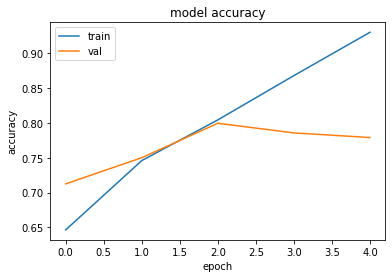

In [20]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


**HEAT MAPS**

In [21]:
import numpy as np

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

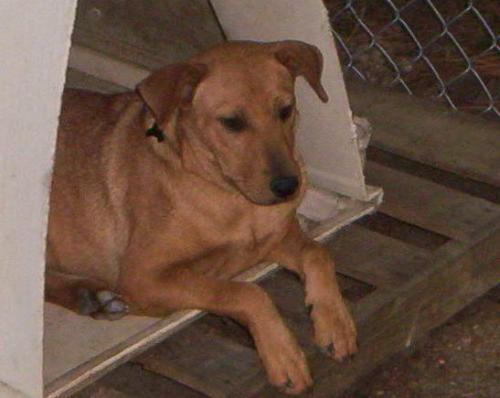

In [22]:
img_size = (180, 180)

last_conv_layer_name = "conv2d_8"

# The local path to our target image
img_path = '/content/PetImages/Dog/100.jpg'
display(Image(img_path))

In [23]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Predicted: [[1]]


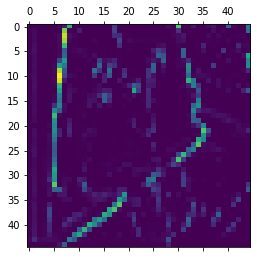

In [31]:
# Prepare image
img_array = get_img_array(img_path, size=img_size)


# Print what the top predicted class is
preds = model_orig.predict(img_array)
result = np.argmax(preds[0])

print("Predicted:", result)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model_orig, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

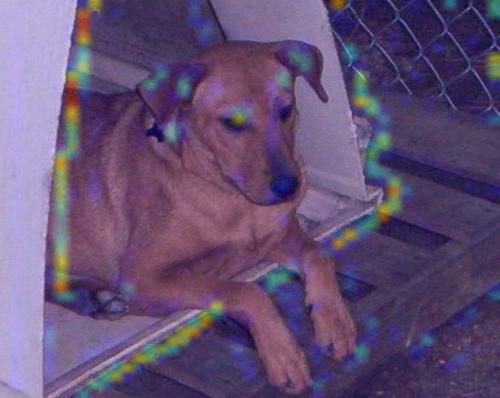

In [36]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

## **Pre trained Models**

In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet',
    input_shape=(180,180,3) 
)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [ ]:
base_model.trainable = False

In [ ]:
from keras import models
from keras import layers

In [ ]:
model_2 = models.Sequential()
model_2.add(base_model)
model_2.add(layers.Flatten())
model_2.add(layers.Dense(256, activation ='relu'))
model_2.add(layers.Dense(1, activation ='sigmoid'))

In [ ]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model_2.fit(train_ds,validation_data=val_ds,epochs=5)

Epoch 1/5
586/586 [==============================] - 73s 124ms/step - loss: 0.0229 - accuracy: 0.9934 - val_loss: 0.2116 - val_accuracy: 0.9624
Epoch 2/5
586/586 [==============================] - 74s 126ms/step - loss: 0.0121 - accuracy: 0.9958 - val_loss: 0.2587 - val_accuracy: 0.9579
Epoch 3/5
586/586 [==============================] - 75s 127ms/step - loss: 0.0116 - accuracy: 0.9965 - val_loss: 0.2370 - val_accuracy: 0.9605
Epoch 4/5
586/586 [==============================] - 75s 127ms/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.2608 - val_accuracy: 0.9622
Epoch 5/5
586/586 [==============================] - 75s 127ms/step - loss: 0.0075 - accuracy: 0.9980 - val_loss: 0.2577 - val_accuracy: 0.9631


In [ ]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_2 (ModuleWrap (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               3277056   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 17,992,001
Trainable params: 3,277,313
Non-trainable params: 14,714,688
_________________________________________________________________


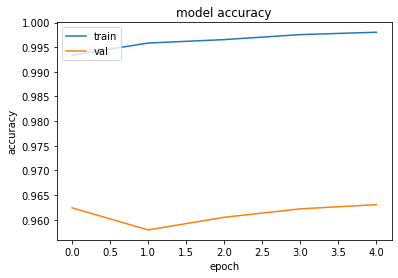

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pwd


/content


In [ ]:
path = '/content/gdrive/My Drive/Dataset/14.jpg'

In [ ]:
from keras.preprocessing import image
import numpy as np

In [ ]:
img = image.load_img(path,target_size=(180,180))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor,axis=0)
img_tensor /= 255.

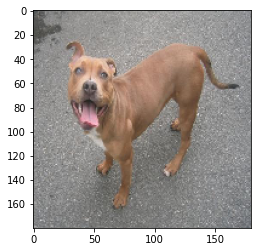

In [ ]:
plt.imshow(img_tensor[0])
plt.show()